In [6]:
!pip install -U efficientnet

In [7]:
from keras import applications
from keras import callbacks
from keras.models import Sequential

In [8]:
import efficientnet.keras as efn

model = efn.EfficientNetB7(weights='imagenet')

268317848/268317848 [==============================] - 2s 0us/step


In [9]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers

In [10]:
!unzip Emergency_Vehicles.zip -d .

Archive:  Emergency_Vehicles.zip
   creating: ./Emergency_Vehicles/
  inflating: ./__MACOSX/._Emergency_Vehicles  
   creating: ./Emergency_Vehicles/test/
  inflating: ./__MACOSX/Emergency_Vehicles/._test  
  inflating: ./Emergency_Vehicles/test.csv  
  inflating: ./__MACOSX/Emergency_Vehicles/._test.csv  
   creating: ./Emergency_Vehicles/train/
  inflating: ./__MACOSX/Emergency_Vehicles/._train  
  inflating: ./Emergency_Vehicles/train.csv  
  inflating: ./__MACOSX/Emergency_Vehicles/._train.csv  
  inflating: ./Emergency_Vehicles/sample_submission.csv  
  inflating: ./__MACOSX/Emergency_Vehicles/._sample_submission.csv  
  inflating: ./Emergency_Vehicles/test/63.jpg  
  inflating: ./__MACOSX/Emergency_Vehicles/test/._63.jpg  
  inflating: ./Emergency_Vehicles/test/2128.jpg  
  inflating: ./__MACOSX/Emergency_Vehicles/test/._2128.jpg  
  inflating: ./Emergency_Vehicles/test/162.jpg  
  inflating: ./__MACOSX/Emergency_Vehicles/test/._162.jpg  
  inflating: ./Emergency_Vehicles/test/61

In [11]:
train_dir = "Emergency_Vehicles/train"
test_dir = "Emergency_Vehicles/test"
train_df = pd.read_csv('Emergency_Vehicles/train.csv')
train_df.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


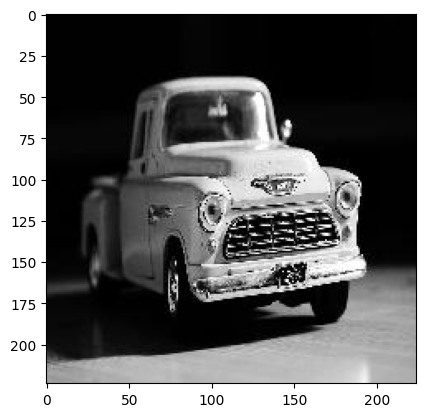

In [12]:
im = cv2.imread("Emergency_Vehicles/train/1002.jpg")
plt.imshow(im)

In [13]:
eff_net = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

258434480/258434480 [==============================] - 7s 0us/step


In [14]:
from keras.preprocessing.image import ImageDataGenerator

In [15]:
#datagen=ImageDataGenerator(rescale=1./255)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # range (0-180) within which to randomly rotate pictures
    width_shift_range=0.2,  # fraction of total width to randomly translate pictures
    height_shift_range=0.2, # fraction of total height to randomly translate pictures
    shear_range=0.2,        # randomly applying shear transformations
    zoom_range=0.2,         # randomly zooming inside pictures
    horizontal_flip=True,   # randomly flipping half of the images horizontally
    fill_mode='nearest'     # strategy used for filling in newly created pixels
)

batch_size=150

In [16]:
train_df.emergency_or_not=train_df.emergency_or_not.astype(str)

In [17]:
train_generator=datagen.flow_from_dataframe(dataframe=train_df[:1150],directory=train_dir,x_col='image_names',
                                            y_col='emergency_or_not',class_mode='binary',batch_size=batch_size,
                                            target_size=(64,64))


validation_generator=datagen.flow_from_dataframe(dataframe=train_df[1151:],directory=train_dir,x_col='image_names',
                                                y_col='emergency_or_not',class_mode='binary',batch_size=50,
                                                target_size=(64,64))

Found 1150 validated image filenames belonging to 2 classes.
Found 495 validated image filenames belonging to 2 classes.


In [18]:
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout

efficient_net = efn.EfficientNetB7(
    weights='imagenet',
    input_shape=(64,64,3),
    include_top=False,
    pooling='max'
)

model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 120, activation='relu'))
model.add(Dropout(0.5))  # randomly sets 50% of input units to 0 at each update during training time
model.add(Dense(units = 120, activation = 'relu'))
model.add(Dropout(0.5))  # randomly sets 50% of input units to 0 at each update during training time
model.add(Dense(units = 1, activation='sigmoid'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b7 (Functional  (None, 2560)             64097680  
 )                                                               
                                                                 
 dense (Dense)               (None, 120)               307320    
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               14520     
                                                                 
 dropout_1 (Dropout)         (None, 120)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 121       
                                                        

In [19]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
%%time
# Train model
'''history = model.fit(
    train_generator,
    epochs = 50,
    steps_per_epoch = 8,
    validation_data = validation_generator,
    validation_steps = 7
)'''

from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # stop training after the validation loss stops improving for 5 epochs
history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=8,
    validation_data=validation_generator,
    validation_steps=7,
    callbacks=[early_stop]  # early stopping
)


Epoch 1/50
8/8 [==============================] - 58s 2s/step - loss: 0.7961 - accuracy: 0.5174 - val_loss: 0.6770 - val_accuracy: 0.6029
Epoch 2/50
8/8 [==============================] - 5s 604ms/step - loss: 0.7715 - accuracy: 0.4991 - val_loss: 0.6737 - val_accuracy: 0.6200
Epoch 3/50
8/8 [==============================] - 9s 1s/step - loss: 0.7533 - accuracy: 0.5417 - val_loss: 0.6729 - val_accuracy: 0.6171
Epoch 4/50
8/8 [==============================] - 11s 1s/step - loss: 0.7325 - accuracy: 0.5339 - val_loss: 0.6773 - val_accuracy: 0.5743
Epoch 5/50
8/8 [==============================] - 5s 604ms/step - loss: 0.7040 - accuracy: 0.5530 - val_loss: 0.6746 - val_accuracy: 0.6000
Epoch 6/50
8/8 [==============================] - 6s 676ms/step - loss: 0.7001 - accuracy: 0.5713 - val_loss: 0.6715 - val_accuracy: 0.6057
Epoch 7/50
8/8 [==============================] - 5s 605ms/step - loss: 0.7162 - accuracy: 0.5452 - val_loss: 0.6709 - val_accuracy: 0.6114
Epoch 8/50
8/8 [===========

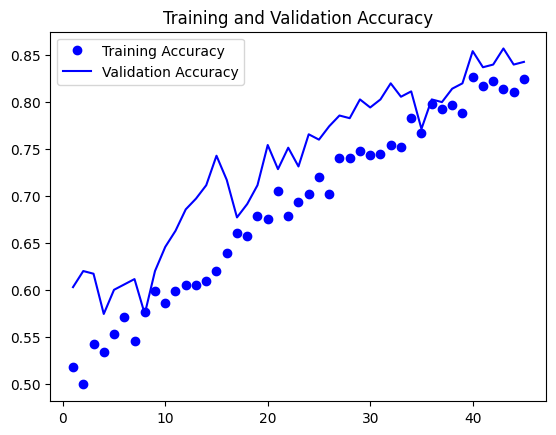

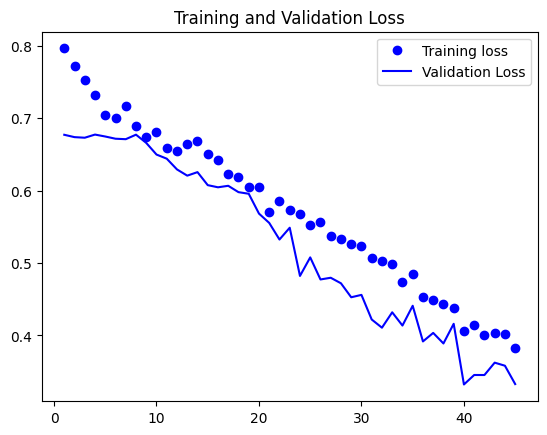

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [22]:
test_df = pd.read_csv('Emergency_Vehicles/test.csv')

test_datagen = ImageDataGenerator(
    rescale=1/255
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = test_dir,
    x_col="image_names",
    target_size=(64,64),
    batch_size=1,
    shuffle=False,
    class_mode=None
)

Found 706 validated image filenames.


In [23]:
preds = model.predict_generator(
    test_generator,
    steps=len(test_generator.filenames)
)

<ipython-input-23-224ef71c1eac>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(


In [24]:
preds

array([[4.92355693e-03],
       [9.68603373e-01],
       [1.84508492e-04],
       [9.60223436e-01],
       [6.98902295e-05],
       [4.15065825e-01],
       [1.80175796e-01],
       [9.94813919e-01],
       [7.51840845e-02],
       [6.44352496e-01],
       [1.64531376e-02],
       [1.51626384e-02],
       [2.86857754e-01],
       [7.27528892e-03],
       [2.20935792e-03],
       [9.72767472e-01],
       [1.74349681e-01],
       [2.96790957e-01],
       [8.56183022e-02],
       [5.14454305e-01],
       [9.23556745e-01],
       [3.57200578e-02],
       [6.38571143e-01],
       [1.18261296e-05],
       [3.63987498e-02],
       [3.23683247e-02],
       [4.23694730e-01],
       [9.53091234e-02],
       [2.86888215e-03],
       [8.34496737e-01],
       [8.92064869e-01],
       [6.08002068e-04],
       [2.40677133e-01],
       [9.98921320e-03],
       [3.13822599e-03],
       [4.95979898e-02],
       [2.28891373e-02],
       [9.99599278e-01],
       [1.62105441e-01],
       [1.66911818e-02],


In [25]:
image_ids = [name.split('/')[-1] for name in test_generator.filenames]
predictions = preds.flatten()
data = {'image_names': image_ids, 'emergency_or_not':predictions}
submission = pd.DataFrame(data)
print(submission.head())

  image_names  emergency_or_not
0    1960.jpg          0.004924
1     668.jpg          0.968603
2    2082.jpg          0.000185
3     808.jpg          0.960223
4    1907.jpg          0.000070


In [26]:
submission['emergency_or_not'] = submission['emergency_or_not'].apply(lambda x: 1 if x > 0.75 else 0)


In [27]:
submission.to_csv('submission_effnet.csv',index=False)


In [28]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix

In [37]:
predicted = pd.read_csv('submission_effnet.csv')
actual = pd.read_csv('test(accurate).csv')

predicted = predicted.head(199)
actual = actual.head(199)
print(predicted)
print(actual)

predicted_labels = predicted['emergency_or_not']
actual_labels = actual['emergency_or_not']

    image_names  emergency_or_not
0      1960.jpg                 0
1       668.jpg                 1
2      2082.jpg                 0
3       808.jpg                 1
4      1907.jpg                 0
..          ...               ...
194     259.jpg                 1
195    1690.jpg                 0
196     948.jpg                 1
197    2343.jpg                 0
198    2278.jpg                 0

[199 rows x 2 columns]
    image_names  emergency_or_not
0      1960.jpg               0.0
1       668.jpg               1.0
2      2082.jpg               0.0
3       808.jpg               1.0
4      1907.jpg               0.0
..          ...               ...
194     259.jpg               0.0
195    1690.jpg               0.0
196     948.jpg               1.0
197    2343.jpg               0.0
198    2278.jpg               0.0

[199 rows x 2 columns]


In [39]:
accuracy = accuracy_score(actual_labels,predicted_labels)
print(f'Accuracy:{accuracy}')


Accuracy:0.7688442211055276


In [40]:
cm = confusion_matrix(actual_labels,predicted_labels)
print('Confusion matrix: ')
print(cm)

Confusion matrix: 
[[112  10]
 [ 36  41]]


Currently, when using our model in the test data, we see that the accuracy is about 0.77. The confusion matrix shows that among the 199 data, 36 emergency vehicles are classified as non-emergency vehicles and 10 non-emergency vehicles are classified as emergency vehicles.

There are some space for improvement.
1. Improve the model for higher validation accuracy
2. Examine the test dataset to see whether there are unclear and ambiguous images.
3. Finish those data manually.
